# TASK 1

### Create an SVM model using data voice.csv with the following conditions:

a. Split the data with a ratio of 70:30 and 80:20 for each model to be built.

1. Use a model with a linear kernel.

2. Use a model with a polynomial kernel.

3. Use a model with an RBF kernel.

b. Tabulate the performance of each split and kernel based on accuracy metrics.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [3]:
df_voice = pd.read_csv("voice .csv")
# Encode textual labels to integers
label_encoder = LabelEncoder()
df_voice['label'] = label_encoder.fit_transform(df_voice['label'])

In [4]:
# Split features / labels
X = df_voice.drop('label', axis=1)
y = df_voice['label']

# Scale features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Function for svm model
def evaluate_svm(X, y, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    # Create and train SVM
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    # Predict on test set and compute accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [15]:
# Run experiments
splits = [0.3, 0.2]  # 70:30 and 80:20
kernels = ['linear', 'poly', 'rbf']

results = []
for split in splits:
    for kernel in kernels:
        acc = evaluate_svm(X_scaled, y, split, kernel)
        results.append({
            'Split': f"{int((1-split)*100)}:{int(split*100)}",
            'Kernel': kernel,
            'Accuracy': acc
        })

In [16]:
# Tabular version
df_results = pd.DataFrame(results)
display(
    df_results.style
        .set_caption("SVM Accuracy Comparison")
        .set_table_styles([
            {'selector': 'caption',
             'props': [('font-size', '16px'),
                       ('font-weight', 'bold'),
                       ('text-align', 'center')]}])
)

,Split,Kernel,Accuracy
0,70:30,linear,0.978970
1,70:30,poly,0.958991
2,70:30,rbf,0.983176
3,80:20,linear,0.974763
4,80:20,poly,0.957413
5,80:20,rbf,0.982650


The table shows the comparison of SVM classification performance using different kernels (linear, polynomial, and RBF) and data split ratios (70:30 and 80:20). Overall, the RBF kernel consistently provides the highest accuracy across both splits indicating that it captures nonlinear patterns more effectively than the linear and polynomial kernels. The results demonstrate that SVM with an RBF kernel delivers the most reliable performance for distinguishing between day and night images, regardless of the data split ratio.


# TASK 2

Use the data from lab 5 to create a day and night classification model using SVM with an RBF kernel using the histrogram feature. Use an 80:20 ratio. You can experiment with hyperparameter tuning of the RBF kernel. Note the accuracy performance!

In [17]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [21]:
def extract_hist_features(directory):
    features, labels, paths = [], [], []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(path))  # ambil nama folder (day/night)
                img = cv2.imread(path)
                if img is None:
                    continue
                img = cv2.resize(img, (128, 128))
                hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8],
                                    [0, 256, 0, 256, 0, 256])
                hist = cv2.normalize(hist, hist).flatten()
                features.append(hist)
                labels.append(label)
                paths.append(path)
    return np.array(features), np.array(labels), paths

DATA_DIR = "images/training/"
X, y, paths = extract_hist_features(DATA_DIR)

In [23]:
print(f"Total images loaded: {len(y)}")
if len(X) > 0:
    print(f"Feature dimension per image: {X.shape[1]}")
else:
    print("No images found! Check your folder structure.")

Total images loaded: 240
Feature dimension per image: 512


In [24]:
# SPLIT DATA 80:20
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, paths, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTraining data: {len(y_train)}")
print(f"Testing data : {len(y_test)}")


Training data: 192
Testing data : 48


In [25]:
# SCALING & ENCODING LABELS
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [26]:
# SVM MODEL RBF 
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 0.01, 0.001]
}

grid = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
print("\nPerforming hyperparameter tuning (GridSearchCV, 5-fold)...")
grid.fit(X_train_scaled, y_train_enc)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid.best_score_:.4f}")


Performing hyperparameter tuning (GridSearchCV, 5-fold)...
Best Parameters: {'C': 1, 'gamma': 0.001}
Best Cross-Validation Accuracy: 0.9843


In [27]:
# EVALUATION 
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nFINAL TEST EVALUATION")
print("===================================")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))



FINAL TEST EVALUATION
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         day       1.00      1.00      1.00        24
       night       1.00      1.00      1.00        24

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



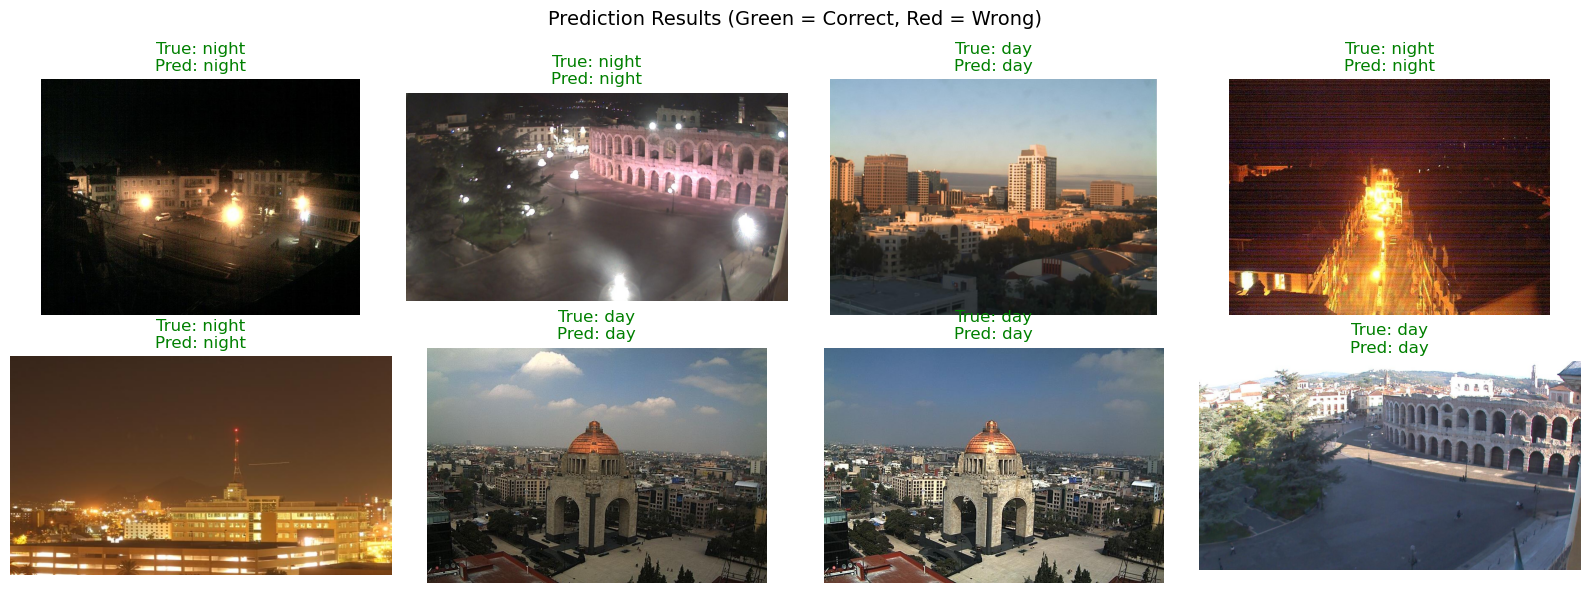

In [28]:
# VISUALIZE 
def show_predictions(paths, y_true, y_pred, le, n=8):
    indices = np.random.choice(len(paths), size=min(n, len(paths)), replace=False)
    plt.figure(figsize=(16, 6))

    for i, idx in enumerate(indices):
        img = cv2.imread(paths[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_rgb)
        true_label = le.inverse_transform([y_true[idx]])[0]
        pred_label = le.inverse_transform([y_pred[idx]])[0]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")

    plt.suptitle("Prediction Results (Green = Correct, Red = Wrong)", fontsize=14)
    plt.tight_layout()
    plt.show()

show_predictions(paths_test, y_test_enc, y_pred, le)

The program builds a day–night image classification model using color histogram features and a Support Vector Machine (SVM) with an RBF kernel. Each image is resized and represented by a 3D RGB histogram (512 features), then standardized before training. The dataset is split into 80% training and 20% testing, and hyperparameter tuning is performed using GridSearchCV to find the best values for `C` and `gamma`. The best model is evaluated on the test data, showing its accuracy and classification report, while several example predictions are displayed to visually confirm the model’s performance in distinguishing between day and night images.
